In [26]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from scipy import signal

# this could possibly also be read from metadata (comment in the first lines of the csv)
# sampling rate in milliseconds
sampling_rate = 20

dance = pd.read_csv("../data/HIMU-2020-05-21_15-07-17.csv", skiprows=3)
# dance = pd.read_csv("../data/HIMU-2020-05-19_08-06-24.csv", skiprows=3)
# dance = pd.read_csv("../data/2020-05-24 17:17:32.135746.csv", skiprows=3)
# dance = pd.read_csv("../data/2020-05-24 17:20:15.555577.csv", skiprows=3)

dance['time'] = dance.reset_index().index * sampling_rate
dance.fillna(value = 0.0)

# duration = dance['timestamp'].max() - dance['timestamp'].min()
dance.describe()

,timestamp,accelerometer_lsm6ds3_c.x,accelerometer_lsm6ds3_c.y,accelerometer_lsm6ds3_c.z,als_B.x,als_B.y,als_B.z,linear_Acceleration.x,linear_Acceleration.y,linear_Acceleration.z,rotation_Vector.x,rotation_Vector.y,rotation_Vector.z,time
count,7.750000e+02,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000,775.000000
mean,1.590066e+12,-0.272243,-6.627919,0.596054,56.652903,437.821935,272.290323,0.095806,0.301054,-0.130690,-0.160988,-0.565208,0.399635,7740.000000
std,3.466654e+04,3.424765,6.162179,4.504005,111.201923,858.304677,537.895540,2.370985,3.743445,2.300315,0.178391,0.286188,0.453589,4477.350407
min,1.590066e+12,-7.755078,-20.170470,-9.707052,0.000000,0.000000,0.000000,-7.033900,-10.449599,-11.900200,-0.561634,-0.802816,-0.944342,0.000000
25%,1.590066e+12,-2.061187,-10.922525,-2.364753,0.000000,0.000000,2.000000,-1.104600,-1.982550,-1.358950,-0.280555,-0.725164,0.507691,3870.000000
50%,1.590066e+12,-0.740440,-7.852675,-0.876364,0.000000,0.000000,2.000000,-0.017000,0.366300,-0.199700,-0.212934,-0.688051,0.607592,7740.000000
75%,1.590066e+12,0.689669,-3.809041,1.922668,0.000000,1.000000,3.000000,1.032450,2.294200,1.176800,-0.113287,-0.655463,0.661898,11610.000000
max,1.590067e+12,23.230670,8.222091,12.642467,426.000000,2347.000000,1489.000000,14.135300,12.203299,9.052300,0.351295,0.664585,0.747644,15480.000000


Depending on what comments are in the csv-file (=lines starting with `@`) You might need to change the skipRows
parameter above.

Once we have imported a csv HyperIMU series, we want to start cleaning it.

But first, let's look at some parts of our dataFrame: the linear_acceleration and rotation_vector data

In [27]:
# dance[['linear_Acceleration.x', 'linear_Acceleration.y', 'linear_Acceleration.z']].plot()
# dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()
tips = sns.load_dataset("tips")
for sensor in ('linear_Acceleration', 'rotation_Vector'):
    fig = go.Figure()
    for axis in ('%s.x', '%s.y', '%s.z'):
        fig.add_trace(go.Scatter(
        y = dance[axis % sensor],
        x = dance['time'],
        mode = 'lines',
        name=axis % sensor
    ))
    fig.update_layout(title=sensor)
    fig.show()

From the rotation vector data, we can easily see that in this example the phone was probably moved to the pocket somewhere
around point 0-25 and out of the pocked around points 135 - 160.

Therefore we can just cut the dataset and use only the rows 25 to 135.

,timestamp,accelerometer_lsm6ds3_c.x,accelerometer_lsm6ds3_c.y,accelerometer_lsm6ds3_c.z,als_B.x,als_B.y,als_B.z,linear_Acceleration.x,linear_Acceleration.y,linear_Acceleration.z,rotation_Vector.x,rotation_Vector.y,rotation_Vector.z,time
100,1590066439346,3.253835,2.690001,8.162619,283.0,2269.0,1446.0,1.0108,-0.1271,-0.9366,0.114250,-0.196698,-0.361979,2000
101,1590066439359,3.158900,1.175467,7.917548,283.0,2269.0,1446.0,1.1598,-1.5770,-0.6135,0.105302,-0.202801,-0.360912,2020
102,1590066439383,2.550304,1.539931,8.105551,283.0,2269.0,1446.0,-1.2492,-1.8615,-0.5929,0.095444,-0.208948,-0.359342,2040
103,1590066439406,3.777485,1.081595,6.625120,283.0,2269.0,1446.0,0.3553,-1.4638,-2.0809,0.079881,-0.222530,-0.349188,2060
104,1590066439425,4.574372,1.020552,6.699561,283.0,2269.0,1446.0,0.5320,-1.9200,-1.8522,0.067673,-0.233409,-0.337860,2080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1590066583935,-5.097370,7.408062,3.373832,234.0,1408.0,663.0,-0.9481,1.6132,-1.6016,0.337914,-0.123089,-0.724943,15400
771,1590066583954,-5.002311,8.222091,4.745940,234.0,1408.0,663.0,-1.6636,3.0559,-2.0268,0.348275,-0.119846,-0.719820,15420
772,1590066583977,-4.885177,5.330710,7.573894,234.0,1408.0,663.0,-1.4582,0.4360,-0.1175,0.351295,-0.118734,-0.717719,15440
773,1590066583996,-3.702949,5.946948,6.884546,234.0,1408.0,663.0,-0.3813,-0.3810,-0.1130,0.348498,-0.117419,-0.717442,15460


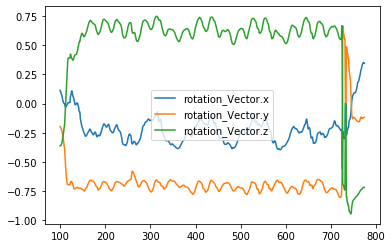

In [28]:
# the start and end variables can later be algorithmically approximated.
# For now, estimating them as constants based on the graph above works just fine.
# TODO: maybe this can also be approximated using the Ambient light sensor in the smartphone?
start=int(5000/50)
end=int(start + 60*1000 / 50)
dance = dance.iloc[start:end]
dance[['rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z']].plot()
dance

# Finding the peaks
For finding the peaks, we need to first find out what the bpm and beats per measure of our current song is:

Luckily, we can use the [get-audio-features spotify-API call](https://developer.spotify.com/console/get-audio-features-track/) for that.

If we call that API with the song ID of Ed Sheeran's Shape of You (```7qiZfU4dY1lWllzX7mPBI3```) we get the following response:


In [29]:
spotify_response = {
  "danceability": 0.825,
  "energy": 0.652,
  "key": 1,
  "loudness": -3.183,
  "mode": 0,
  "speechiness": 0.0802,
  "acousticness": 0.581,
  "instrumentalness": 0,
  "liveness": 0.0931,
  "valence": 0.931,
  "tempo": 95.977,
  "type": "audio_features",
  "id": "7qiZfU4dY1lWllzX7mPBI3",
  "uri": "spotify:track:7qiZfU4dY1lWllzX7mPBI3",
  "track_href": "https://api.spotify.com/v1/tracks/7qiZfU4dY1lWllzX7mPBI3",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/7qiZfU4dY1lWllzX7mPBI3",
  "duration_ms": 233713,
  "time_signature": 4
}
time_signature = spotify_response['time_signature']
bpm = spotify_response['tempo']
duration = spotify_response['duration_ms'] / 1000

time_between_beats = 60 / bpm
time_between_bars = time_between_beats * time_signature

# now let's add that beat information to the chart of the rotation axis:

def plot_series_with_beats(axis: str):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = dance[axis],
        x = dance['time']/1000,
        mode = 'lines',
        name=axis
    ))

    ymin = dance[axis].min()
    ymax = dance[axis].max()

    # generate beat definitions
    shapes = []
    count = 0
    i = dance['time'].min()
    while i < dance['time'].max():
        count += 1
        i += int(time_between_beats * 1000)
        shapes.append(dict(type= 'line', xref= 'x', x0 =i/1000.0, x1 = i/1000.0, y0= ymin, y1= ymax))
        if count % time_signature == 0:
            shapes[-1]['line'] = dict(color="Red")
            # we color every fourth beat red to show how long a bar is (maybe misleading since this
            # is not necessarily the start or end of a bar


    fig.update_layout(title=axis, shapes = shapes)
    fig.show()

plot_series_with_beats('linear_Acceleration.y')

Since we now have bot the dancing sensor signal and our metadata of the song,
we can now focus on calculating the rhythm of the dancer.

In [30]:
from scipy.signal import argrelextrema
import numpy as np

# calculate how many data points a beat is long
samples_per_second = 1000 / sampling_rate
samples_per_beat = samples_per_second * time_between_beats

def find_peaks_for_series(series: np.ndarray):
    order = int(samples_per_beat / 2)
    peaks = argrelextrema(series, comparator=np.greater, order = order)[0]
    return peaks

def find_peak_diffs(series: pd.Series):
    peaks = find_peaks_for_series(series.values)
    time_stamps = dance['time'].values
    diff_peak = np.diff(time_stamps[peaks], n = 1)
    return diff_peak

def visualize_peaks(axis: str, printme: bool):
    peaks = find_peaks_for_series(dance[axis].values)
    time_stamps = dance['time'].values

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y = dance[axis],
        x = dance['time']/1000,
        mode = 'lines',
        name=axis
    ))

    fig.add_trace(go.Scatter(
        x=[time_stamps[j]/1000 for j in peaks],
        y=[dance[axis].values[j] for j in peaks],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='cross'
        ),
        name='Detected Peaks'
    ))

    fig.show()

    if printme:
        fig.write_image('peaks_%s.png' % axis)

# local_maxima = find_peaks_for_series(dance['rotation_Vector.z'].values)
# local_minima = find_peaks_for_series(-dance['rotation_Vector.z'].values)
# extrema = np.concatenate(local_maxima, local_minima)
# extrema

visualize_peaks('linear_Acceleration.z', False)
# visualize_peaks('rotation_Vector.z')
diffs = find_peak_diffs(dance['linear_Acceleration.z'])
# find_peak_diffs(dance['rotation_Vector.z'])
print(diffs)
np.median(diffs)

[ 500  600  560 1140  540  600  620  760  440  620  680  580  580  460
  560  720  580  600  780  720]


600.0

On first glance it looks like in this time series we found a rhythm of the person moving every approximately 1.8 seconds
(or twice that speed if we assume both negative and positive peaks are a movement?)

next steps:
- Check if other axis have similar peaks and peakDiffs
- Check how we can best compare beat and peakDiff values
- Calculate consistency in movement (stddev of peakDiffs?)

In [55]:
from scipy.stats import stats

def analyze_peak_diffs(axis: str):
    diffs = find_peak_diffs(dance[axis])

    # remove outliers outside of IQR according to https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
    q1 = np.quantile(diffs, .25)
    q3 = np.quantile(diffs, .75)
    iqr = q3 - q1
    filtered_diffs = diffs[(diffs > q1 - 1.5*iqr) & (diffs < q3 + 1.5*iqr)]
    # filtered_diffs = diffs[(diffs > q1 - 1*iqr) & (diffs < q3 + 1*iqr)]

    filtered_out = 1 - filtered_diffs.size / diffs.size
    mean_diff = np.mean(filtered_diffs)

    # print(filtered_diffs)
    # print(mean_diff)

    # calculating the coefficient of variation according to https://en.wikipedia.org/wiki/Coefficient_of_variation

    coeff_of_variation = np.std(filtered_diffs) / mean_diff

    # maybe we can also use something like a confidence-interval here?

    # peak_diffs right now has the time between beats, but we actually want the bpm here...
    print(mean_diff)
    calculated_bpm = 60 * 1000  / mean_diff
    return calculated_bpm, coeff_of_variation, filtered_out

# Let's try the analysis for one time series to show the result:
cb, cv, outliers = analyze_peak_diffs('linear_Acceleration.z')
print("Outliers filtered: %.2f%%" % (outliers * 100))
print("Bpm: %f" % cb)
print("Coefficient of variance: %f" % cv)


605.2631578947369
Outliers filtered: 5.00%
Bpm: 99.130435
Coefficient of variance: 0.150030


In [32]:
# compare results for all axis
all_axis = list(['linear_Acceleration.x', 'linear_Acceleration.y', "linear_Acceleration.z", 'rotation_Vector.x', 'rotation_Vector.y', 'rotation_Vector.z'])
df = pd.DataFrame(data = all_axis, columns=["axis"])

df['calculated_bpm'], df['coeff_of_variance'], df['percentage_filtered'] = zip(*df['axis'].map(analyze_peak_diffs))
# sort by best confidence
df = df.sort_values('coeff_of_variance')
# filter out data with cv = 0 (since that's very unrealistic
df = df.where(df['coeff_of_variance'] > 0).dropna()
df

,axis,calculated_bpm,coeff_of_variance,percentage_filtered
1,linear_Acceleration.y,99.792100,0.071022,0.058824
5,rotation_Vector.z,100.000000,0.106719,0.111111
4,rotation_Vector.y,100.934579,0.133078,0.052632
2,linear_Acceleration.z,99.130435,0.150030,0.050000
0,linear_Acceleration.x,84.112150,0.453440,0.000000
3,rotation_Vector.x,65.015480,0.499384,0.000000


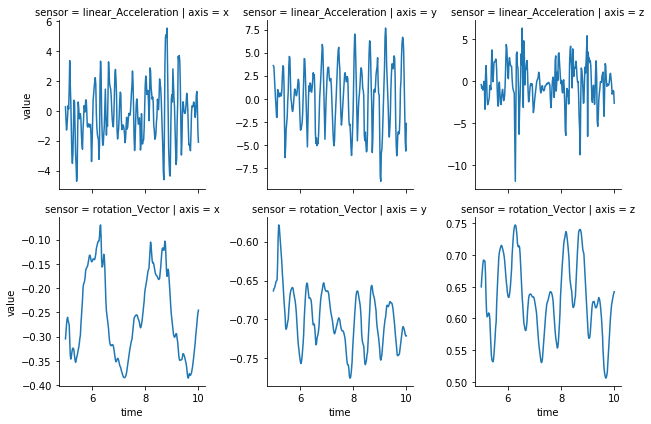

In [53]:
# from second, to second
start = 5
end = 10


start = start * 1000
end = end * 1000

# some more plots...
melted_dance = pd.melt(dance[(dance.time >= start) & (dance.time <= end)], id_vars=['timestamp', 'time'], value_vars=all_axis)
def split_sensor_to_sensor_and_axis(col: str):
    l= col.split(sep = '.')
    return l[0], l[1]
melted_dance['sensor'], melted_dance['axis'] = zip(*melted_dance['variable'].apply(split_sensor_to_sensor_and_axis))
melted_dance['time'] = melted_dance['time'].divide(1000)
g = sns.FacetGrid(data = melted_dance, row = 'sensor', col = 'axis', sharey=False)
g = g.map(plt.plot, 'time', 'value')
plt.savefig('facetgrid.png')
plt.show()
